In [59]:
import nest_asyncio
nest_asyncio.apply()

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from skimage.util import random_noise
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
import random

warnings.filterwarnings(action = 'ignore')

random.seed(1337)

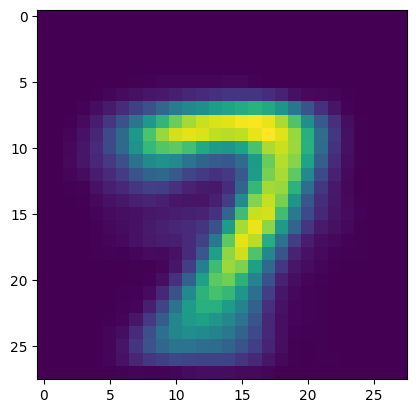

In [61]:
### Read in Data
image_data = pd.read_csv("image_data.csv")

# Compute the mean image
mu = np.mean(image_data, axis = 0)

images_centered = image_data - mu

# Reshape the mean image to 28x28
mu_image = mu.values.reshape(28, 28)

# Plot the mean image
plt.imshow(mu_image)
plt.show()

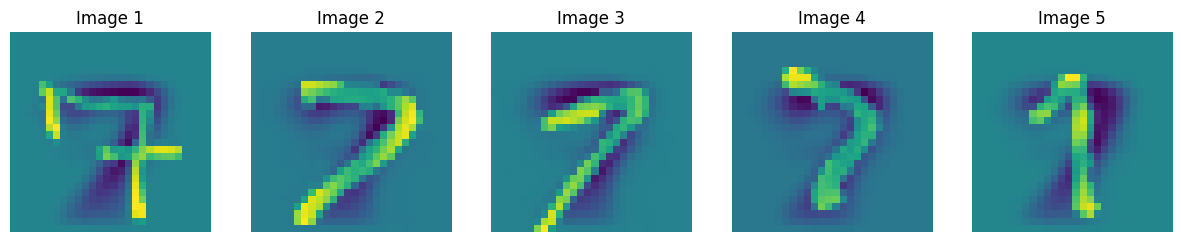

In [62]:
### Plot 5 Images at Random

random_indices = np.random.choice(len(images_centered), 5, replace = False)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, (ax, idx) in enumerate(zip(axes, random_indices)):
    ax.imshow(images_centered.iloc[idx].values.reshape(28, 28))
    ax.axis('off')
    ax.set_title(f"Image {i + 1}")
plt.show()

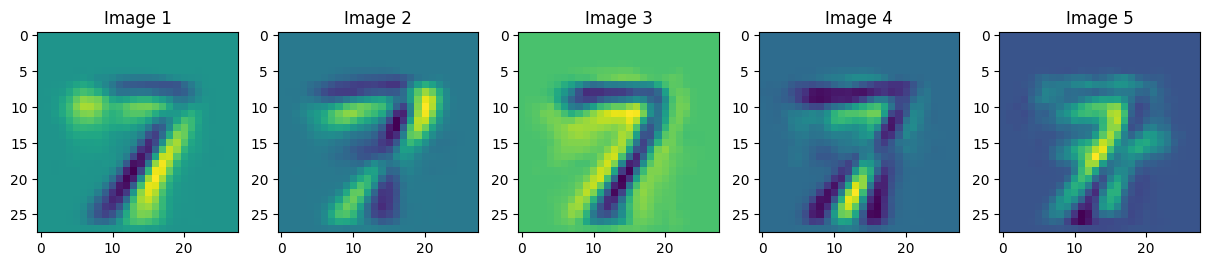

In [63]:
### Plot Eigenvectors and Eigenvalues

# Find covariance matrix
cov_matrix = np.cov(images_centered, rowvar = False)

# Find eigenvalues/eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
index = np.argsort(eigenvalues)[::-1]
eigenvalues_sort = np.real(eigenvalues[index])
eigenvectors_sort = np.real(eigenvectors[:, index])

# Plot the first 5 eigenvectors in a row
fig, axes = plt.subplots(1, 5, figsize = (15, 3))
for i, ax in enumerate(axes):
    eigenvector = eigenvectors_sort[:, i].reshape(28, 28)
    axes[i].set_title(f"Image {i + 1}")
    ax.imshow(eigenvector)

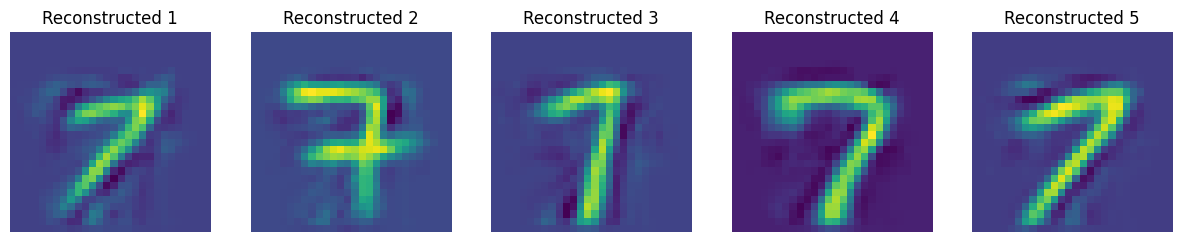

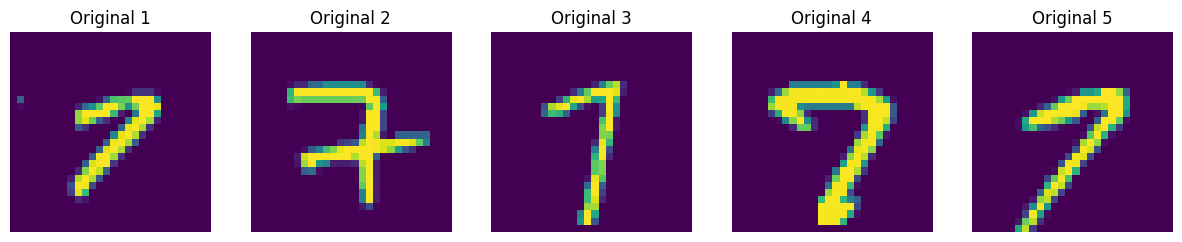

In [64]:
### Reconstruct Images with PCA

eigenvector25 = eigenvectors_sort[:, :25]
eigenvector25_norm = eigenvector25 / np.linalg.norm(eigenvector25, axis = 0)

# Find z
z = np.dot(images_centered, eigenvector25_norm)

mu_image_1d = mu_image.reshape(1, -1)

# Reconstruct images
reconstructed = np.dot(z, eigenvector25_norm.T) + mu_image_1d

# Plot 5 reconstructed images in a row with titles
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed[i].reshape(28, 28))
    ax.axis('off')
    ax.set_title(f"Reconstructed {i + 1}")
plt.show()

# Plot 5 original images in a row with titles
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(image_data.iloc[i].values.reshape(28, 28))
    ax.axis('off')
    ax.set_title(f"Original {i + 1}")
plt.show()

In [65]:
### Create a Linear Autoencoder and Load Dataset

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, dtype = torch.float64)

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, dtype = torch.float64)

    def forward(self, z):
        z = self.fc(z)
        return z

# Define parameters
input_dim = 28 * 28 
output_dim = 25

# Initialize encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)

lr = 0.001
batch_size = 5
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

# Data to tensors
transform = torch.tensor

# Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [66]:
### Train the Linear Autoencoder
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")

Epoch [1/10], Loss: 0.072975883553217
Epoch [2/10], Loss: 0.04187241964572658
Epoch [3/10], Loss: 0.03412160219714529
Epoch [4/10], Loss: 0.03026792199413193
Epoch [5/10], Loss: 0.027751682532474203
Epoch [6/10], Loss: 0.025667886176015946
Epoch [7/10], Loss: 0.02398692667172581
Epoch [8/10], Loss: 0.022631531433549183
Epoch [9/10], Loss: 0.02159846800719799
Epoch [10/10], Loss: 0.020628245689906323


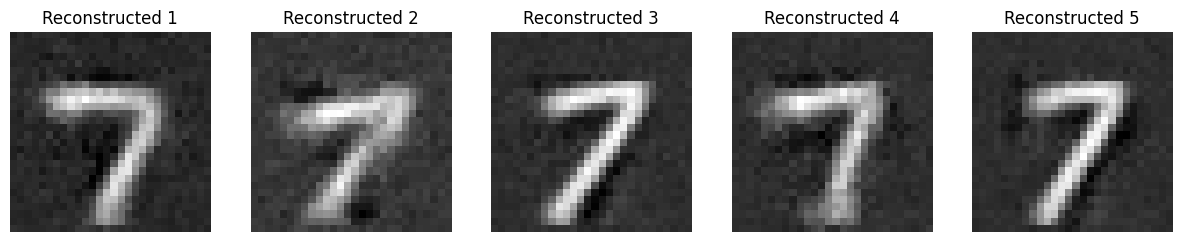

In [67]:
### Reconstruct Images with Autoencoder

images = next(iter(data_loader))

with torch.no_grad():
    encoded_images = encoder(images)
    reconstructed_images = decoder(encoded_images)

# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i].view(28, 28).numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Reconstructed {i + 1}")
plt.show()

In [68]:
### Define Non-Linear Autoencoder and Load Dataset

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) 
        self.relu = nn.ReLU()  

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x)) 
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64)
        self.sigmoid = nn.Sigmoid()  

    def forward(self, z):
        z = self.fc1(z)
        z = self.sigmoid(self.fc2(z)) 
        return z

# Parameters
input_dim = 28 * 28  # Size 28x28
output_dim = 25

# Encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)

lr = 0.001
batch_size = 5
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

# Data to tensors
transform = torch.tensor

# Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [69]:
### Train the Non-Linear Autoencoder

# Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

# Train
for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")

Epoch [1/10], Loss: 0.07605109265279378
Epoch [2/10], Loss: 0.03926889823866356
Epoch [3/10], Loss: 0.031731000652665306
Epoch [4/10], Loss: 0.02900331883752294
Epoch [5/10], Loss: 0.02709594856156163
Epoch [6/10], Loss: 0.02458121673356292
Epoch [7/10], Loss: 0.022436121514083855
Epoch [8/10], Loss: 0.020895117005389225
Epoch [9/10], Loss: 0.01921308874474805
Epoch [10/10], Loss: 0.017738730889074135


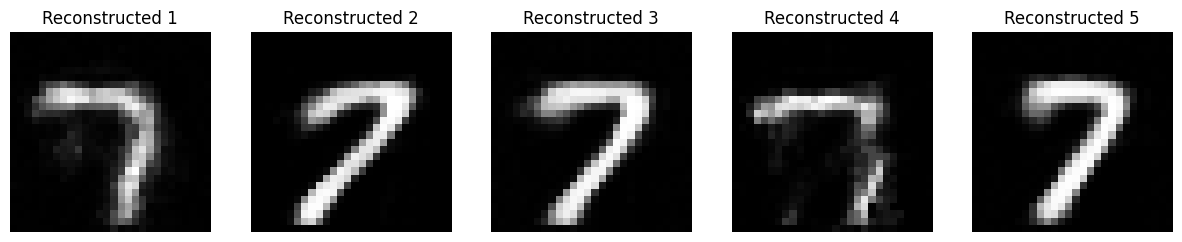

In [70]:
### Reconstruct Images with Autoencoder

images = next(iter(data_loader))

with torch.no_grad():
    encoded_images = encoder(images)
    reconstructed_images = decoder(encoded_images) 

# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Reconstructed {i + 1}")
plt.show()

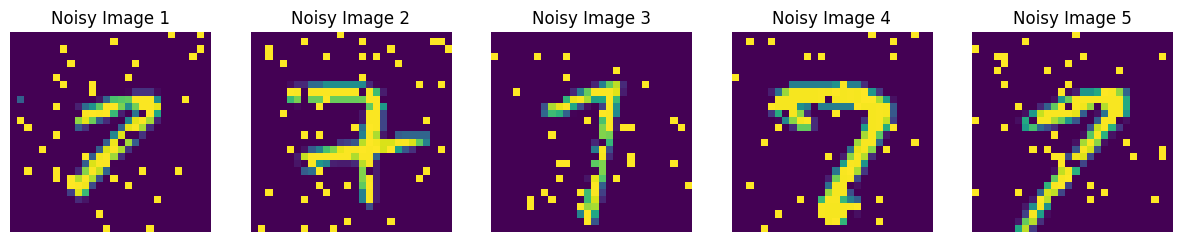

In [71]:
### Read in Data with Noise

image_data = pd.read_csv("image_data.csv").values

for i in range(len(image_data)):
    image_data[i] = random_noise(image_data[i], mode = 's&p', amount = 0.1)

# Plot 5 noisy images in a row with titles
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(image_data[i].reshape(28, 28))
    ax.axis('off')
    ax.set_title(f"Noisy Image {i + 1}")
plt.show()

In [72]:
### Define Denoising Autoencoder and Load Dataset

class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64)  
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) 
        self.relu = nn.ReLU()  

    def forward(self, x):
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))  
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128, dtype = torch.float64) 
        self.fc2 = nn.Linear(128, output_dim, dtype = torch.float64) 
        self.sigmoid = nn.Sigmoid()  

    def forward(self, z):
        z = self.fc1(z)
        z = self.sigmoid(self.fc2(z)) 
        return z

# Parameters
input_dim = 28 * 28
output_dim = 25

# Encoder and decoder
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)

lr = 0.001
batch_size = 5
epochs = 10

class Dataset(Dataset):
    def __init__(self, csv_file, transform = None):
        self.data = pd.read_csv(csv_file, dtype = "float64")
        self.transform = transform
        
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

csv_file = 'image_data.csv'

# Data to tensors
transform = torch.tensor

# Data
dataset = Dataset(csv_file, transform = transform)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

In [73]:
### Train the Denoising Autoencoder

# Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = lr)

# Train
for epoch in range(epochs):
    running_loss = 0.0
    for data in data_loader:
        inputs = data 
        optimizer.zero_grad()
        encoded = encoder(inputs)
        decoded = decoder(encoded)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader)}")

Epoch [1/10], Loss: 0.07873088843026185
Epoch [2/10], Loss: 0.03929933233652402
Epoch [3/10], Loss: 0.03268466172694536
Epoch [4/10], Loss: 0.02968510838464495
Epoch [5/10], Loss: 0.027668184509454137
Epoch [6/10], Loss: 0.025037939320612074
Epoch [7/10], Loss: 0.022735723796878264
Epoch [8/10], Loss: 0.020903166723048414
Epoch [9/10], Loss: 0.019247230339318567
Epoch [10/10], Loss: 0.017720626461139


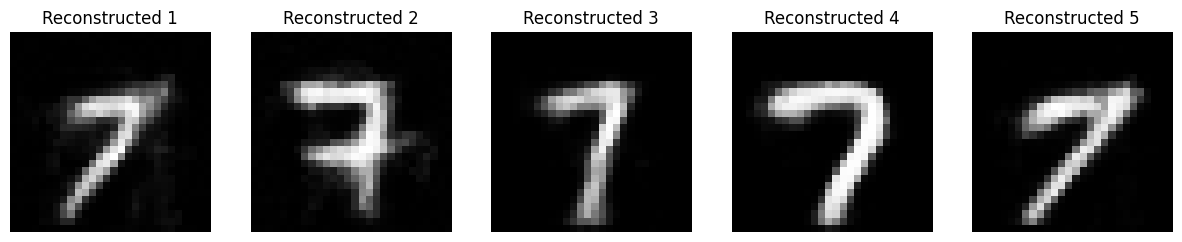

In [74]:
### Reconstruct Images with Autoencoder

images = next(iter(data_loader))

with torch.no_grad():
    encoded_images = encoder(images) 
    reconstructed_images = decoder(encoded_images) 

# Plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i].view(28, 28).cpu().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Reconstructed {i + 1}")
plt.show()